sample =  469


/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


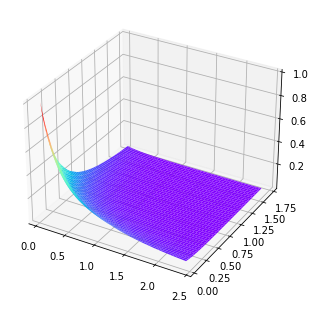

In [238]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import train
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d

def get_new_decay(decay_data, b, t, max_ending):
    decay_dim = 100
    decay_data = decay_data / decay_data[0, 0]

    max_row = np.max(decay_data, axis=1)
    max_col = np.max(decay_data, axis=0)
    row_position = np.where(max_row > max_ending)
    col_position = np.where(max_col > max_ending)
    new_b = b[row_position]
    new_t = t[col_position]

    new_t = np.linspace(np.min(new_t), np.max(new_t), decay_dim)
    new_b = np.linspace(np.min(new_b), np.max(new_b), decay_dim)

    interp_func = interp2d(t, b, decay_data, kind='cubic')
    decay_data = interp_func(new_t, new_b)
    decay_data = decay_data / decay_data[0, 0]

    range_D = np.linspace(0.01, 1, 100)
    range_T = np.linspace(0.01, 1, 100)
    KD = np.exp(-np.dot(new_b[:, np.newaxis], 1 / range_D[np.newaxis, :]))
    KT = np.exp(-np.dot(new_t[:, np.newaxis], 1 / range_T[np.newaxis, :]))

    concat_data = np.concatenate([KD[np.newaxis, :, :], decay_data[np.newaxis, :, :], KT[np.newaxis, :, :]])

    return decay_data, concat_data, new_b, new_t, range_D, range_T

epoch = 300
with torch.no_grad():
    # checkpoint = torch.load('Experiments/SimpleViT_230512_203404/checkpoints/epoch_{num}.pth'.format(num=epoch), map_location=DEVICE )
    # checkpoint = torch.load('Experiments/T2T2_lin_auto_48/SimpleViT_lambda=0.4/checkpoints/last.pth')
    # checkpoint = torch.load('Experiments/SimpleViT_230723_202022/checkpoints/epoch_300.pth')
    checkpoint = torch.load('Experiments/SimpleViT_230725_191622/checkpoints/epoch_300.pth')
    args = checkpoint['args']
    module = train.set_module(args)
    module.load_state_dict(checkpoint['model'])
    module.to(args.device)
    module.eval()

val_input = np.load("./Dataset/valid_input.npy")
val_label = np.load("./Dataset/valid_label.npy")
sample = np.random.randint(0, 2000)
print('sample = ', sample)
# sample = 1839
# sample = 1884
# sample = 213
# sample = 902
sample = 102

test_input = val_input[sample]
b = np.linspace(0.05, 5, 100)
t = np.linspace(0.05, 5, 100)

scio.savemat('Results/GRIN_In4.mat', {'y':test_input, 'v1':b, 'v2':t})
new_decay, concat_data, y_new, x_new, range_D, range_T = get_new_decay(test_input, b, t, 0.03)
test_input = torch.tensor(concat_data).unsqueeze(0).to(args.device)
test_input = test_input.to(torch.float32)

test_out = module(test_input)
test_out = test_out.cpu().detach().numpy()

figure = plt.figure(1)
axes = Axes3D(figure)
X,Y = np.meshgrid(x_new, y_new)
axes.plot_surface(X,Y,new_decay,cmap='rainbow')

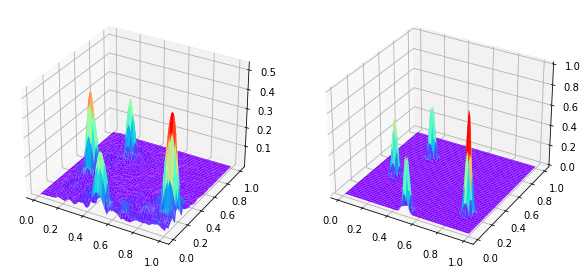

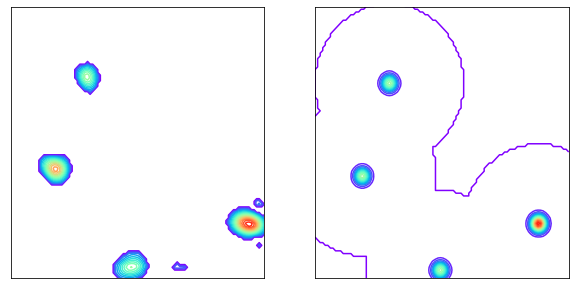

In [239]:
def blocks_threshold(image, block_size, gamma):
    height, width = image.shape
    new_image = np.zeros([height, width])
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = image[y:y+block_size, x:x+block_size]
            threshold = min([np.max(block)*gamma, 0.08])
            # threshold = np.max(block)*gamma
            block[block<threshold]=0
            new_image[y:y+block_size, x:x+block_size] = block
    return new_image

label_dim = 100

figure = plt.figure(4, figsize=[10, 5])
axes1 = figure.add_subplot(121, projection='3d')
axes2 = figure.add_subplot(122, projection='3d')

X = np.linspace(0.01, 1, 100)
Y = np.linspace(0.01, 1, 100)
X,Y = np.meshgrid(X, Y)

Z = test_out[0].reshape(label_dim, label_dim)
axes1.plot_surface(X,Y,Z,cmap='rainbow')
axes2.plot_surface(X,Y,val_label[sample],cmap='rainbow')
plt.show()

Z = blocks_threshold(Z, 40, 0.5)
Z[Z<0.03]=0
plt.figure(1, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, 20, cmap='rainbow')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.contour(X, Y, val_label[sample], 20, cmap='rainbow')
plt.xticks([])
plt.yticks([])
plt.show()

In [240]:
scio.savemat('Results/DILT_Out4.mat', {'DILT_Out':Z, 'label':val_label[sample]})